<a href="https://colab.research.google.com/github/BhanuHarshaY/Automatic-Speech-Recognition-NLP/blob/main/Assignment11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **ASSIGNMENT11 |Automatic Speech Recognition|AUTHOR: BHANU HARSHA Y | DT: 11/22/25**

In [ ]:
# Install all required libraries
!pip install openai-whisper
!pip install librosa
!pip install pydub
!pip install spacy
!pip install jiwer
!pip install matplotlib
!pip install scikit-learn
!pip install wordcloud

# Download spaCy model
!python -m spacy download en_core_web_sm

# Import all required libraries
from google.colab import files
import zipfile
from pathlib import Path
import whisper
import librosa
import librosa.display
import soundfile as sf
from pydub import AudioSegment
import numpy as np
import matplotlib.pyplot as plt
import os
import spacy
import re
from collections import Counter
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from jiwer import wer
import seaborn as sns
from wordcloud import WordCloud

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Imported all required libraries!")

In [3]:
#UPLOADING DATASET
print("Please upload the dataset zip file (127105-1-1.zip)")
uploaded = files.upload()

# Extracting the zip file
with zipfile.ZipFile('127105-1-1.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

print("\nDataset extracted successfully!")

Please upload the dataset zip file (127105-1-1.zip)


Saving 127105-1-1.zip to 127105-1-1.zip

Dataset extracted successfully!


## **Q1) DATA COLLECTION: READING AND ANALYZING AUDIO FILES:**

DATA COLLECTION: READING, ANALYZING, AND TRANSCRIBING AUDIO FILES
Loading Whisper model


100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 74.4MiB/s]



Found 37 audio files in the dataset

Loading and Transcribing audio files:
121-127105-0006: 4.72s @ 16000Hz | PCM_16 | 86.06KB
121-127105-0000: 9.88s @ 16000Hz | PCM_16 | 177.60KB
121-127105-0032: 3.17s @ 16000Hz | PCM_16 | 62.91KB
121-127105-0031: 10.77s @ 16000Hz | PCM_16 | 173.29KB
121-127105-0009: 2.29s @ 16000Hz | PCM_16 | 52.35KB
121-127105-0008: 2.76s @ 16000Hz | PCM_16 | 52.83KB
121-127105-0033: 2.35s @ 16000Hz | PCM_16 | 43.00KB
121-127105-0030: 2.17s @ 16000Hz | PCM_16 | 42.41KB
121-127105-0025: 16.07s @ 16000Hz | PCM_16 | 301.52KB
121-127105-0027: 13.87s @ 16000Hz | PCM_16 | 257.05KB
121-127105-0003: 7.72s @ 16000Hz | PCM_16 | 137.91KB
121-127105-0016: 2.03s @ 16000Hz | PCM_16 | 45.20KB
121-127105-0005: 5.82s @ 16000Hz | PCM_16 | 109.36KB
121-127105-0023: 10.91s @ 16000Hz | PCM_16 | 209.78KB
121-127105-0035: 14.15s @ 16000Hz | PCM_16 | 205.99KB
121-127105-0001: 5.03s @ 16000Hz | PCM_16 | 102.02KB
121-127105-0019: 3.52s @ 16000Hz | PCM_16 | 68.95KB
121-127105-0010: 2.85s @ 1

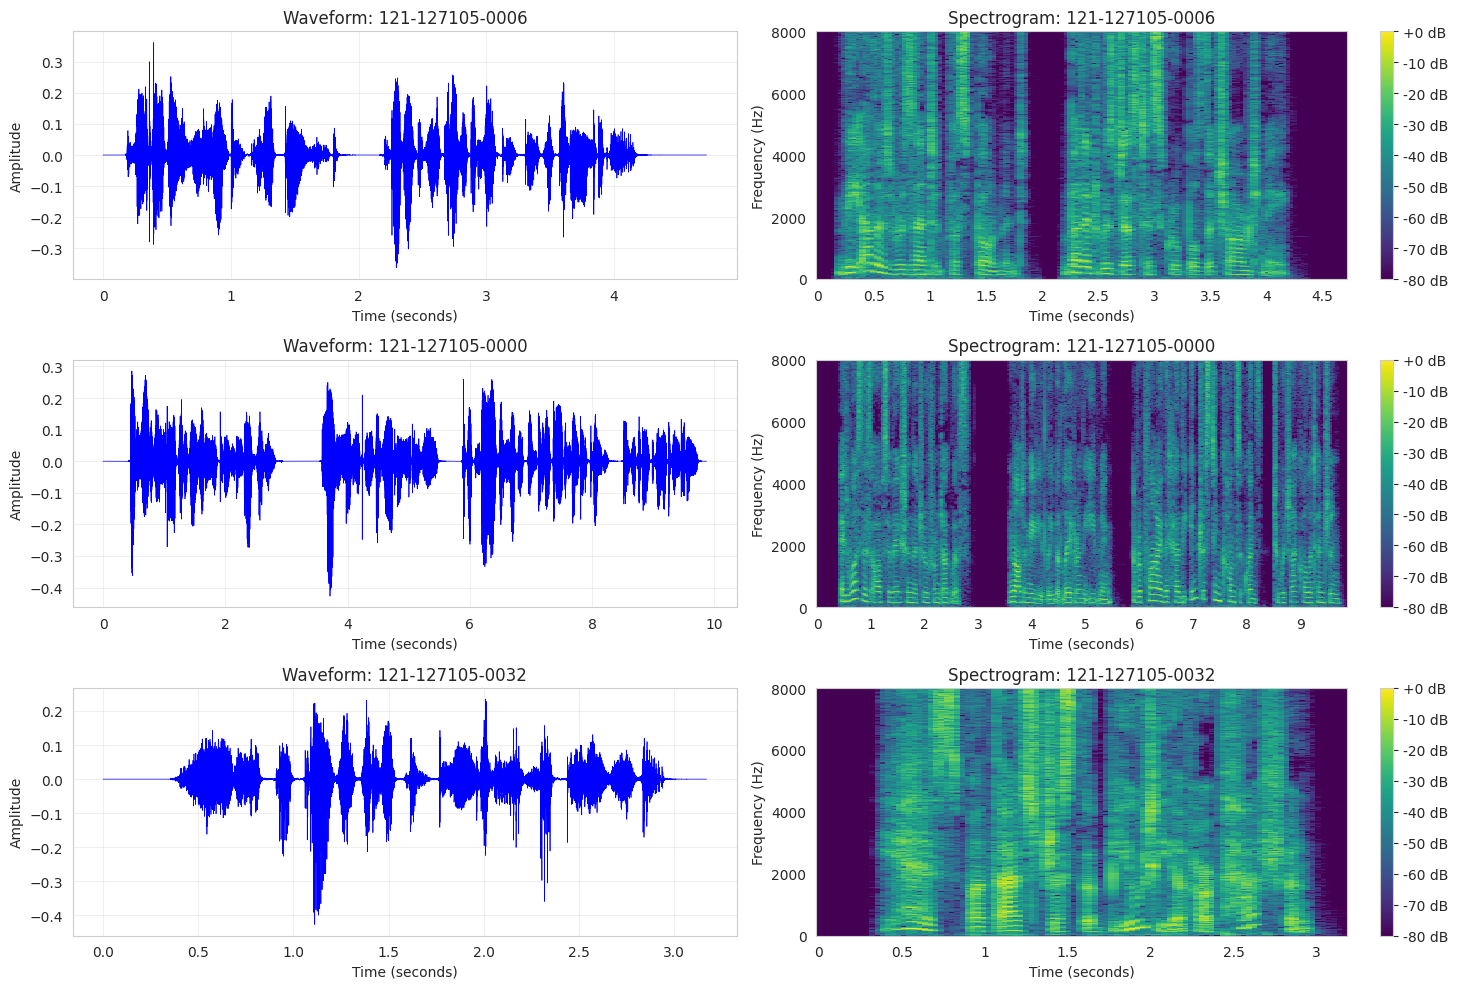


Sample Transcription:
File: 121-127105-0006
Text:  The others resented postponement, but it was just his groupels that charmed me.


In [4]:
# Q1
print("DATA COLLECTION: READING, ANALYZING, AND TRANSCRIBING AUDIO FILES")

# Loading Whisper Model
print("Loading Whisper model")
model = whisper.load_model("base")

data_dir = Path('127105')

# Finding all audio files (.flac format)
audio_files = list(data_dir.glob('*.flac'))
print(f"\nFound {len(audio_files)} audio files in the dataset")

# Loading and analyzing the audio files
audio_data = {}
audio_stats = []

print("\nLoading and Transcribing audio files:")

for audio_file in audio_files:
    # File Size and Bit Depth
    file_size_bytes = os.path.getsize(audio_file)
    file_size_kb = file_size_bytes / 1024

    # sf.info for Bit depth
    sf_info = sf.info(audio_file)
    bit_depth = sf_info.subtype

    # Transcribe with Whisper
    result = model.transcribe(str(audio_file),fp16=False)
    transcription = result['text']

    # Load audio with Librosa
    audio_signal, sample_rate = librosa.load(audio_file, sr=None)

    # Calculating duration
    duration = len(audio_signal) / sample_rate

    # Storing audio data
    file_id = audio_file.stem
    audio_data[file_id] = {
        'signal': audio_signal,
        'sample_rate': sample_rate,
        'duration': duration,
        'file_path': str(audio_file)
    }

    # Calculating statistics for analysis
    audio_stats.append({
        'file_id': file_id,
        'duration_sec': duration,
        'sample_rate': sample_rate,
        'bit_depth': bit_depth,
        'file_size_kb': file_size_kb,
        'transcription': transcription,
        'num_samples': len(audio_signal),
        'mean_amplitude': np.mean(np.abs(audio_signal)),
        'std_amplitude': np.std(audio_signal),
        'max_amplitude': np.max(np.abs(audio_signal)),
        'rms_energy': np.sqrt(np.mean(audio_signal**2))
    })

    print(f"{file_id}: {duration:.2f}s @ {sample_rate}Hz | {bit_depth} | {file_size_kb:.2f}KB")

# DF for statistics
stats_df = pd.DataFrame(audio_stats)

print("\nAUDIO STATISTICS SUMMARY")

print("\nDataset Overview:")
print(f"Total files: {len(audio_files)}")
print(f"Total duration: {stats_df['duration_sec'].sum():.2f} seconds")
print(f"Average duration: {stats_df['duration_sec'].mean():.2f} seconds")
print(f"Sample rate: {stats_df['sample_rate'].iloc[0]} Hz")
print(f"Bit Depth: {stats_df['bit_depth'].iloc[0]}")
print(f"Average File Size: {stats_df['file_size_kb'].mean():.2f} KB")

print("\nAmplitude Statistics:")
print(stats_df[['mean_amplitude', 'std_amplitude', 'max_amplitude', 'rms_energy']].describe())

# Visualizing audio samples
print("\nVisualizing sample audio files.")
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

# Selecting first 3 audio files for visualization
sample_files = list(audio_data.keys())[:3]

for idx, file_id in enumerate(sample_files):
    audio = audio_data[file_id]['signal']
    sr = audio_data[file_id]['sample_rate']
    duration = audio_data[file_id]['duration']

    # Plot waveform
    time_axis = np.linspace(0, duration, len(audio))
    axes[idx, 0].plot(time_axis, audio, color='blue', linewidth=0.5)
    axes[idx, 0].set_title(f'Waveform: {file_id}')
    axes[idx, 0].set_xlabel('Time (seconds)')
    axes[idx, 0].set_ylabel('Amplitude')
    axes[idx, 0].grid(True, alpha=0.3)

    # Plot spectrogram
    D = librosa.stft(audio, n_fft=2048, hop_length=512)
    D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(D_db, sr=sr, x_axis='time', y_axis='hz',
                                   ax=axes[idx, 1], cmap='viridis')
    axes[idx, 1].set_title(f'Spectrogram: {file_id}')
    axes[idx, 1].set_xlabel('Time (seconds)')
    axes[idx, 1].set_ylabel('Frequency (Hz)')
    plt.colorbar(img, ax=axes[idx, 1], format='%+2.0f dB')

plt.tight_layout()
plt.show()

# sample transcription
print("\nSample Transcription:")
print(f"File: {stats_df.iloc[0]['file_id']}")
print(f"Text: {stats_df.iloc[0]['transcription']}")

## **Q1 D&A**
# **Discussion:**

*   In this code snippet, I uploaded and extracted all `37 FLAC audio files` from the `LibriSpeech` dataset subset.
*   I used `soundfile` library to extract all technical metadata.
* And `librosa` for audio loading and analysis, extracting key features like duration, amplitude statistics and RMS energy.
* I visualised `time vs amplitude` using `waveform`.
* Visualised `frequency vs time` using `spectrogram`.

# **Analysis:**

1.   **Sampling rate:** The sampling rate of the provided audio files is `16,000 Hz (16 kHz)` . while talking about it's importance in speech recognition, it is considered as the industry standard. A `16 kHz sample rate` `captures` `frequencies` up to `8 kHz`. This rate **captures** all **necessary phonetic information**.
2. **Duration:** The duration of each audio file varies from file to another, and the audio clips are short with an `average duration` of `6.26 seconds` and a `maximum` of roughly `16 seconds`.
3. **Bit depth and it's effect:** The output shows the files are encoded as `PCM_16 (16-bit)`. It differentiates between the quietest and loudest possible sounds. A `16-bit` depth offers a theoretical `dynamic range` of approximately `96 dB`. This is `critical for ASR` because it provides enough `resolution to distinguish` subtle `speech sounds from silence`.
4. **File size:**  The `average file size` is `115.68 KB`, with a `range` generally between `30 KB and 300 KB`. Since the sampling rate (16 kHz) and bit depth (16-bit) are constant across the dataset, the file size is directly proportional to the duration.
5. **Transcription:** The sample transcription ("The others resented postponement, but it was just his groupels that charmed me.") demonstrates that the Whisper model successfully processed the 16 kHz audio.




---
## **Q2) TEXT PRE PROCESSING**

In [7]:
# Q2
print("TEXT PREPROCESSING usinf SpaCy")
#loading spacy
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading SpaCy model...")
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# Text pre processing
def spacy_clean_text(text):
    # Lowercase
    text = text.lower()

    #removing filler words
    filler_pattern = r"\b(um|uh|hmm|like|you know)\b"
    text = re.sub(filler_pattern, "", text)

    # C. SpaCy Processing (Tokenize, Lemmatize, Stopwords, Punctuation)
    doc = nlp(text)

    clean_tokens = []
    for token in doc:

        if not token.is_stop and not token.is_punct and not token.is_space:

            clean_tokens.append(token.lemma_)

    return " ".join(clean_tokens)

# Loading transcripts
transcript_file = list(data_dir.glob('*.txt'))[0]
transcripts = {}
with open(transcript_file, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split(' ', 1)
        if len(parts) == 2:
            transcripts[parts[0]] = parts[1]

print(f"Loaded {len(transcripts)} transcripts.")


original_texts = list(transcripts.values())
processed_texts = [spacy_clean_text(text) for text in original_texts]

# Results & Statistics
print("\n Preprocessing Comparison")
for i in range(min(3, len(original_texts))):
    print(f"Original:  {original_texts[i][:80]}...")
    print(f"Processed: {processed_texts[i][:80]}...")


# Analyzing text characteristics
all_words = ' '.join(processed_texts).split()
word_freq = Counter(all_words)
unique_words = len(set(all_words))
total_words = len(all_words)

print("\n--- Text Statistics After SpaCy Cleaning ---")
print(f"Total words: {total_words}")
print(f"Unique words: {unique_words}")
print(f"Avg words per transcript: {total_words/len(processed_texts):.1f}")

print("\nTop 15 Most Common Words:")
for word, count in word_freq.most_common(15):
    print(f"  {word}: {count}")

TEXT PREPROCESSING usinf SpaCy
Loaded 37 transcripts.

 Preprocessing Comparison
Original:  IT WAS THIS OBSERVATION THAT DREW FROM DOUGLAS NOT IMMEDIATELY BUT LATER IN THE ...
Processed: observation draw douglas immediately later evening reply interesting consequence...
Original:  SOMEONE ELSE TOLD A STORY NOT PARTICULARLY EFFECTIVE WHICH I SAW HE WAS NOT FOLL...
Processed: tell story particularly effective see follow...
Original:  CRIED ONE OF THE WOMEN HE TOOK NO NOTICE OF HER HE LOOKED AT ME BUT AS IF INSTEA...
Processed: cry woman take notice look instead see speak...

--- Text Statistics After SpaCy Cleaning ---
Total words: 240
Unique words: 188
Avg words per transcript: 6.5

Top 15 Most Common Words:
  story: 5
  tell: 4
  take: 4
  know: 4
  lady: 4
  douglas: 3
  woman: 3
  write: 3
  thank: 3
  say: 3
  stay: 3
  little: 3
  immediately: 2
  later: 2
  reply: 2


## **Q2 D&A**
# **Discussion:**
In this part, I implemented `text preprocessing` pipeline using the `SpaCy library (en_core_web_sm)`. The pipeline performs `4 key operations`:

1.  **Normalization:** I have  converted all text to lowercase to ensure case consistency.
2. **Filler Removal:** I used `Regular Expressions (re)` to `strip out` specific disfluencies `(e.g., "um", "uh", "you know")` before passing the text to the NLP model.
3. **Stopword Removal:** Using `SpaCy's built-in stopword list`, I `filtered out` high-frequency, low-meaning words (like "the", "is", "and") to focus on semantic content.
4. **Lemmatization:** I converted words to their base roots (lemmas), ensuring that variations like "running" and "ran" are treated as the same concept ("run").

# **Analysis:**

**Effect of Preprocessing:** If we `compare` the `original text` to the `processed text`, we see a significant reduction in noise. The `"Top 15 Words"` list `shifted` from `generic articles ("the", "a") `to `meaningful content words`, nouns and verbs specific to the context.

**Handling misrecognized or misspelled Words:** In this `current implementation`, `misspellings` are treated as `unique tokens`. SpaCy does not automatically correct spelling; it simply tokenizes what it sees. `To address` this, a `spell-checking` library like `pyspellchecker` could be integrated before the tokenization step to correct terms based on `Levenshtein distance` from known vocabulary.

**Handling Multilingual or Code-Switched Text:**  If the `transcripts` contained `multiple languages`, the current `en_core_web_sm model` would `fail` to correctly `lemmatize non-English words`. `To address` that we would need to introduce a `Language Identification step` using a tool like `langdetect or fasttext` and iterate through sentences, detect the language, and `dynamically` switch the `SpaCy model`.

---
## **Q3) EXPLORATORY DATA ANALYSIS**

EXPLORATORY DATA ANALYSIS (EDA)

Text Analysis


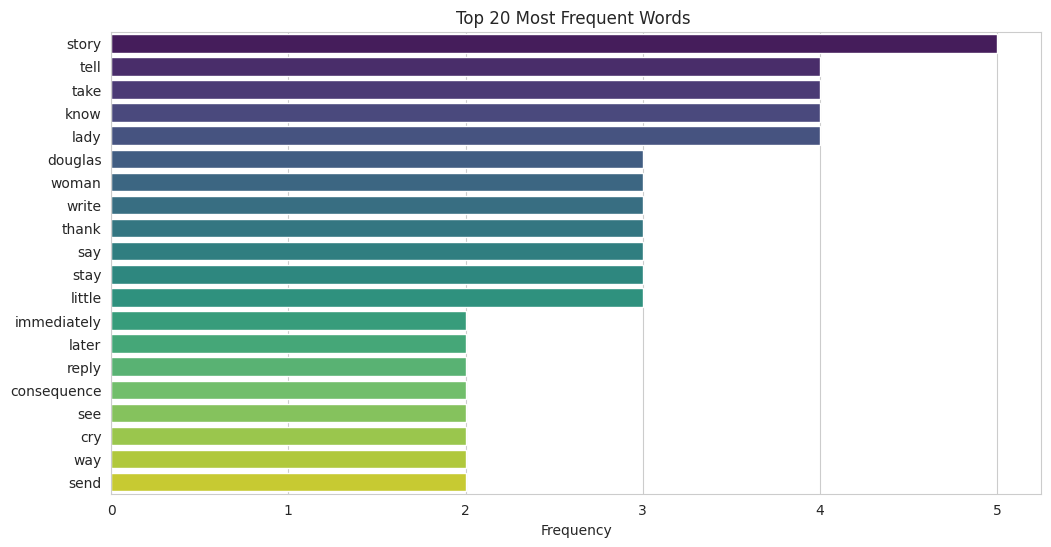

Total Unique Words: 188
Hapax Legomena (occur once): 154
Examples: ['observation', 'draw', 'evening', 'interesting', 'attention']

Audio Analysis


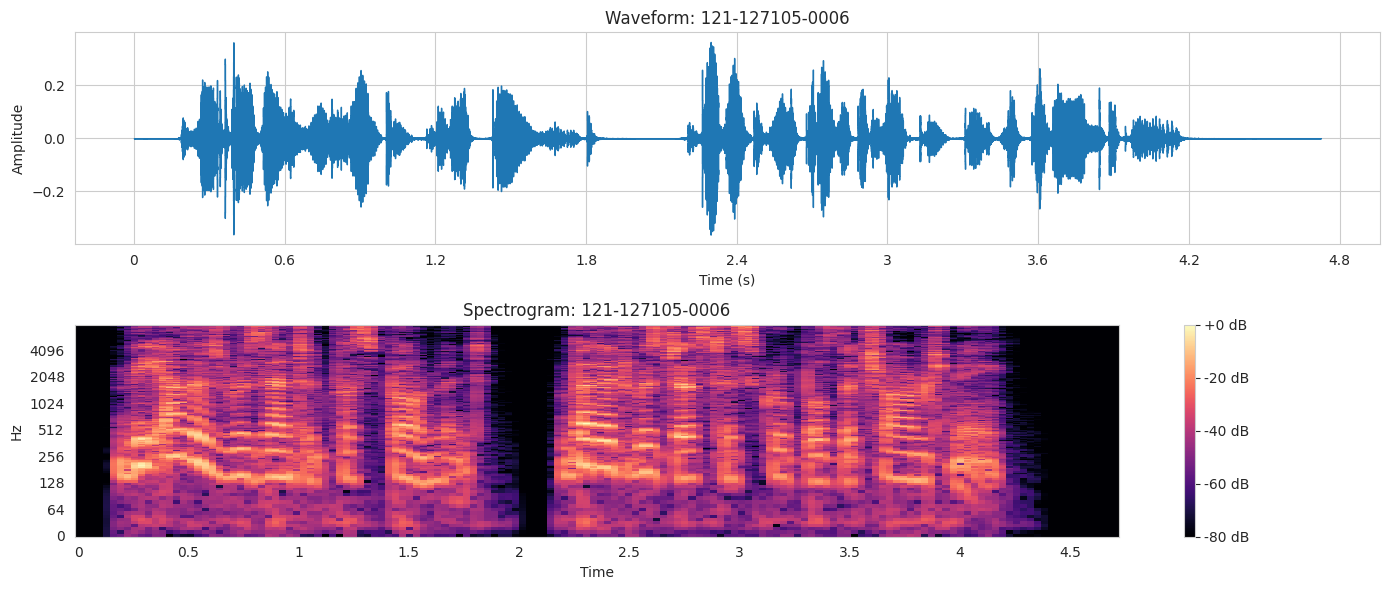

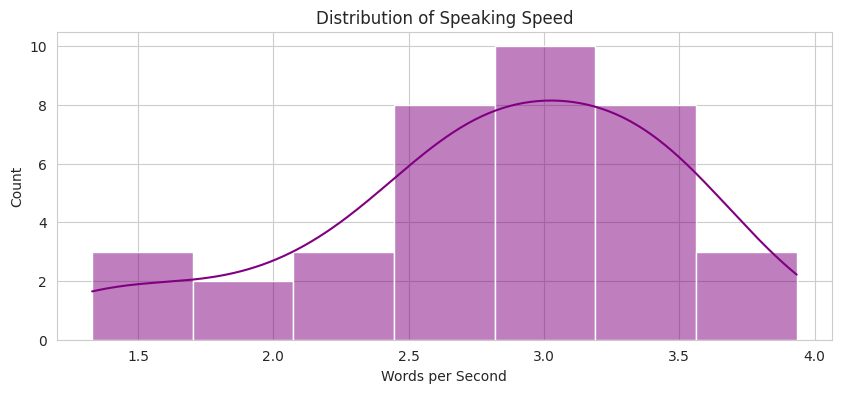

Avg Speaking Speed: 2.82 words/sec

 Disfluency Analysis
Total Filler Words Found: 0
Breakdown: {'um': 0, 'uh': 0, 'hmm': 0, 'you know': 0, 'like': 0}


In [11]:
# Q3

print("EXPLORATORY DATA ANALYSIS (EDA)")

#PART 1: TEXT EDA
print("\nText Analysis")

# Flattening all processed text into a single list of words
all_clean_words = ' '.join(processed_texts).split()
word_freq = Counter(all_clean_words)

# 1. Visualize Top 20 Words
common_words = word_freq.most_common(20)
words, counts = zip(*common_words)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), palette='viridis', hue=list(words), legend=False)
plt.title("Top 20 Most Frequent Words ")
plt.xlabel("Frequency")
plt.show()

# 2. Hapax Legomena (Words appearing exactly once)
hapax_legomena = [word for word, count in word_freq.items() if count == 1]
print(f"Total Unique Words: {len(word_freq)}")
print(f"Hapax Legomena (occur once): {len(hapax_legomena)}")
print(f"Examples: {hapax_legomena[:5]}")


# PART 2: AUDIO EDA
print("\nAudio Analysis")

# 3. Plot Waveform & Spectrogram for ONE file
sample_id = stats_df.iloc[0]['file_id']
sample_audio = audio_data[sample_id]['signal']
sample_sr = stats_df.iloc[0]['sample_rate']

plt.figure(figsize=(14, 6))

# Waveform
plt.subplot(2, 1, 1)
librosa.display.waveshow(sample_audio, sr=sample_sr)
plt.title(f'Waveform: {sample_id}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Spectrogram
plt.subplot(2, 1, 2)
D = librosa.stft(sample_audio)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
librosa.display.specshow(S_db, sr=sample_sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spectrogram: {sample_id}')
plt.tight_layout()
plt.show()

# 4. Speaking Speed Analysis
# Calculate words per second for every file
def calculate_speed(row):

    word_count = len(row['transcription'].split())
    return word_count / row['duration_sec']

stats_df['words_per_sec'] = stats_df.apply(calculate_speed, axis=1)

plt.figure(figsize=(10, 4))
sns.histplot(stats_df['words_per_sec'], kde=True, color='purple')
plt.title("Distribution of Speaking Speed")
plt.xlabel("Words per Second")
plt.show()

print(f"Avg Speaking Speed: {stats_df['words_per_sec'].mean():.2f} words/sec")

# 5. Disfluency Analysis (Counting 'um', 'uh', etc. )
fillers = ['um', 'uh', 'hmm', 'you know', 'like']
total_fillers = 0
filler_counts = Counter()

for text in stats_df['transcription']:

    for f in fillers:
        count = len(re.findall(r"\b" + f + r"\b", text.lower()))
        total_fillers += count
        filler_counts[f] += count

print("\n Disfluency Analysis")
print(f"Total Filler Words Found: {total_fillers}")
print("Breakdown:", dict(filler_counts))

## **Q3 D&A**
# **Discussion:**
Here, I first performed **Text EDA** and then **Audio EDA**:


*   **Text EDA :** I analyzed the `vocabulary distribution` of the preprocessed transcripts and `generated` a `bar chart` of the `top 20 most frequent words`  and calculated the `count` of `"Hapax Legomena"`, words that appear exactly once to measure the richness and diversity of the vocabulary.
*   **Audio EDA:** I examined the `audio signal properties` visually and statistically. And then I plotted the `waveform and spectrogram` of a `sample file (121-127105-0006)` to inspect the `signal amplitude` and `frequency distribution` over time. Additionally,I engineered a new feature, `Speaking Speed (words per second)`, to analyze the pacing of the speakers. Finally, I performed a `regex-based` search on the transcripts to `quantify "disfluencies" `(filler words like "um", "uh", "you know") to determine the fluency and spontaneity of the speech.

# **Analysis:**


1.  **Top 20 Words**: The `bar chart` reveals that the most frequent words are content heavy terms such as `"story", "tell", "lady", "Douglas", and "write"`. The absence of stopwords and the specific nature of these nouns and verbs strongly suggest that the `source material` is `narrative literature or storytelling`, rather than technical or conversational dialogue.
2.  **Vocabulary Richness (Hapax Legomena):** The analysis shows a very `high proportion` of `unique words`. Out of `188 total unique words`, `154 (approx. 82%) are Hapax Legomena`. This indicates an extremely `diverse vocabulary` with very little repetition. For an ASR system, this presents a `challenge` known as the `"long tail"` problem, where the model must be able to recognize a vast array of rare words rather than just a few common commands.
3. **Waveform:** The plot for file `121-127105-0006` shows a `high Signal-to-Noise Ratio (SNR)`. There are `distinct high-amplitude` bursts corresponding to speech, `separated by periods` of `near-zero amplitude (silence)`. This indicates the recording environment was quiet and the audio is clean.
4. **Spectrogram:** The spectrogram displays `clear horizontal bands`  in the `lower frequencies`, which represent the vowels, and distinct vertical lines representing consonant onsets.
5. **speaking speed:** The `average speaking speed` is `2.82 words per second`. This is consistent with a deliberate, professional reading pace.
6. **Disfluency:** The analysis found `0 occurrences of filler words ("um", "uh", "like")`. This is a critical finding. It confirms that the dataset consists of `scripted, read speech likely audiobooks` rather than spontaneous conversation.

---
## **Q4)FEATURE EXTRACTION:**

QUESTION 4: FEATURE EXTRACTION ANALYSIS

 Text Feature Extraction (BoW vs. TF-IDF) 

Bag of Words Shape: (37, 20)
Top 20 BoW Features: ['begin' 'consequence' 'douglas' 'know' 'lady' 'little' 'reply' 'reward'
 'say' 'see' 'send' 'sound' 'stay' 'story' 'take' 'tell' 'thank' 'touch'
 'woman' 'write']

TF-IDF Shape: (37, 20)
Top 20 TF-IDF Features: ['begin' 'consequence' 'douglas' 'know' 'lady' 'little' 'reply' 'reward'
 'say' 'see' 'send' 'sound' 'stay' 'story' 'take' 'tell' 'thank' 'touch'
 'woman' 'write']


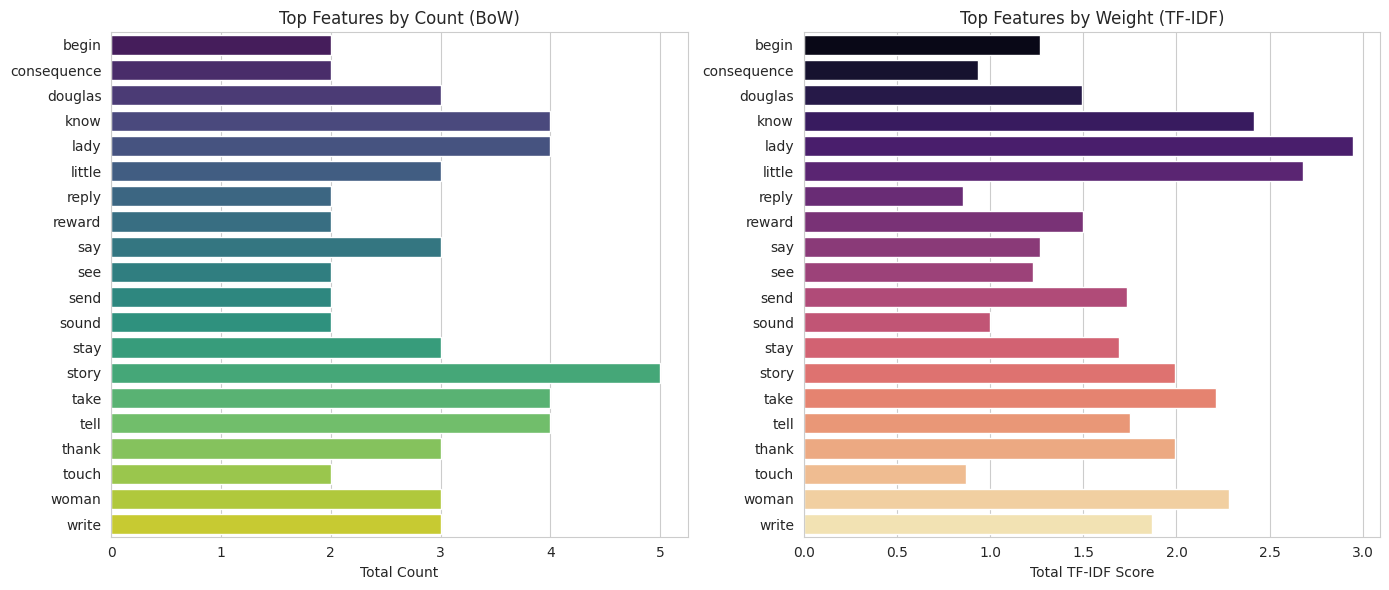


Audio Feature Extraction (MFCCs)
File: 121-127105-0006
Audio Duration: 4.72 seconds
MFCC Matrix Shape: (13, 148) (Coefficients x Time Frames)


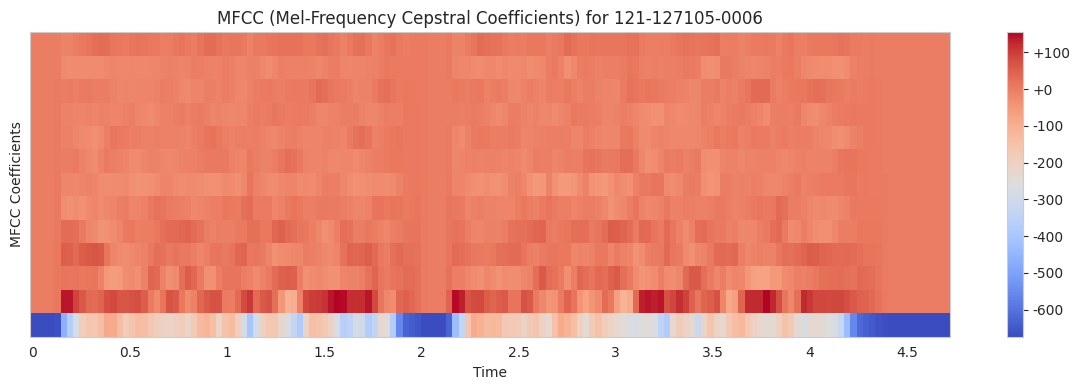

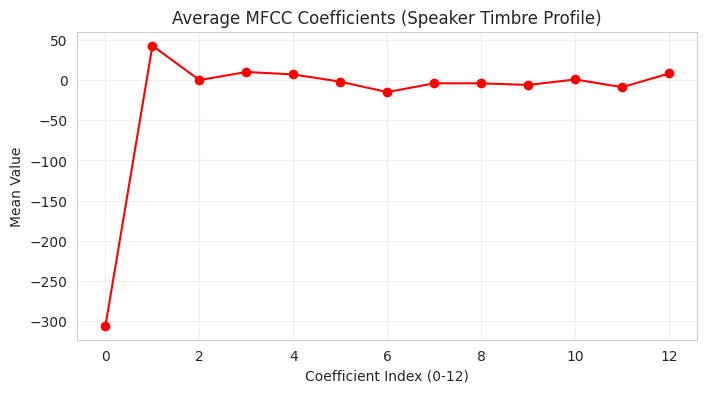

In [14]:
#  Q4

print("QUESTION 4: FEATURE EXTRACTION ANALYSIS")

#PART 1: TEXT-BASED FEATURE EXTRACTION
print("\n Text Feature Extraction (BoW vs. TF-IDF) ")

# A. Bag of Words (BoW)
count_vect = CountVectorizer(ngram_range=(1, 2), max_features=20)
bow_matrix = count_vect.fit_transform(processed_texts)
bow_features = count_vect.get_feature_names_out()

print(f"\nBag of Words Shape: {bow_matrix.shape}")
print(f"Top 20 BoW Features: {bow_features}")

# B. TF-IDF
tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), max_features=20)
tfidf_matrix = tfidf_vect.fit_transform(processed_texts)
tfidf_features = tfidf_vect.get_feature_names_out()

print(f"\nTF-IDF Shape: {tfidf_matrix.shape}")
print(f"Top 20 TF-IDF Features: {tfidf_features}")

# Comparison Visualization
bow_sums = bow_matrix.sum(axis=0).A1
tfidf_sums = tfidf_matrix.sum(axis=0).A1

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=bow_sums, y=bow_features, palette="viridis",hue= bow_features, legend=False)
plt.title("Top Features by Count (BoW)")
plt.xlabel("Total Count")

plt.subplot(1, 2, 2)
sns.barplot(x=tfidf_sums, y=tfidf_features, palette="magma", hue= tfidf_features, legend=False)
plt.title("Top Features by Weight (TF-IDF)")
plt.xlabel("Total TF-IDF Score")

plt.tight_layout()
plt.show()


# PART 2: AUDIO-BASED FEATURE EXTRACTION (MFCC)
print("\nAudio Feature Extraction (MFCCs)")

# Extracting MFCCs for the first audio file in our dataframe
sample_id = stats_df.iloc[0]['file_id']
sample_audio = audio_data[sample_id]['signal']
sample_sr = stats_df.iloc[0]['sample_rate']

mfccs = librosa.feature.mfcc(y=sample_audio, sr=sample_sr, n_mfcc=13, hop_length=512)

print(f"File: {sample_id}")
print(f"Audio Duration: {len(sample_audio)/sample_sr:.2f} seconds")
print(f"MFCC Matrix Shape: {mfccs.shape} (Coefficients x Time Frames)")

# Visualize MFCC
plt.figure(figsize=(12, 4))
librosa.display.specshow(mfccs, sr=sample_sr, hop_length=512, x_axis='time')
plt.colorbar(format='%+2.0f')
plt.title(f'MFCC (Mel-Frequency Cepstral Coefficients) for {sample_id}')
plt.ylabel('MFCC Coefficients')
plt.tight_layout()
plt.show()

# Visualize MFCC Mean
plt.figure(figsize=(8, 4))
plt.plot(np.mean(mfccs, axis=1), marker='o', color='r')
plt.title("Average MFCC Coefficients (Speaker Timbre Profile)")
plt.xlabel("Coefficient Index (0-12)")
plt.ylabel("Mean Value")
plt.grid(True, alpha=0.3)
plt.show()

## **Q4 D&A**
# **Discussion:**


*  **Text-Based Feature Extraction:** I implemented two `vectorization techniques`. **Bag of Words (BoW)** using CountVectorizer and **TF-IDF (Term Frequency-Inverse Document Frequency)**. Limited both to the top 20 features (unigrams and bigrams) to compare how they prioritize words differently.
*  **Audio-Based Feature Extraction:** I extracted **MFCCs (Mel-Frequency Cepstral Coefficients)** using `librosa`. And computed `13 coefficients per time frame`, which is the standard configuration for speech recognition tasks, and visualized them as a `heatmap`.

# **Analysis:**
**Text Feature Comparison (TF-IDF vs. BoW):**

*  Interestingly, the `top 20 features` identified by BoW and TF-IDF are `identical` containing words like "begin", "douglas", "lady", "story". This indicates that in this specific subset of transcripts, the most frequent words are also the most statistically significant.
*   While the lists are the same, the `priorities differ`.
* In the `BoW plot`, the word `"story"` has the `highest bar count` of 5, indicating it is the most frequently used word.
* In the `TF-IDF plot`, the word `"lady"` has the `highest score` approx 3.0, surpassing "story".

**Audio Feature Analysis (**MFCCs**):**

* The **MFCC matrix shape** is `(13, 148)`. This confirms that for the 4.72-second audio file, the system calculated `13 coefficients`  over `148 distinct time frames`.

* The **heatmap** shows the evolution of these coefficients over time. The `bottom row (Coefficient 0)` shows `deep red/blue` contrasts, representing significant changes in energy (loudness) as the speaker talks and pauses.

* The `higher rows (Coefficients 1-12)` show `complex textures` that correspond to the changing shape of the vocal tract .

* The **"Average MFCC Coefficients" plot** reveals a `distinct pattern` a very low negative value for Coefficient 0 (approx -300) followed by a spike at Coefficient 1 and stabilization near zero for the rest.

**My choice of Downstream Task Selection:**
* **For Semantic Tasks:** I would use the `ASR Output (Text) features (TF-IDF)`. If the goal is to categorize the audiobooks by genre (e.g., "Mystery" vs "Romance"), the presence of words like "Douglas" or "Lady" is far more predictive than the sound of the voice.

* **For Paralinguistic Tasks:** I would use the `MFCC features`. If the goal is to detect the `speaker's emotion ` (e.g., "Angry" vs "Calm") or identify the `gender of the speaker`, the text "the lady walked" contains no useful information, whereas the `MFCCs capture `the `pitch dynamics and intensity` required for such classification.


---
## **Q5) ASR MODEL EVALUATION:**

 ASR MODEL EVALUATION
Loading Whisper ASR model

Transcribing audio files
Completed transcription of 37 files

Preparing texts for WER calculation...

Calculating Word Error Rates
EVALUATION RESULTS

Overall WER: 0.0260 (2.60%)
Average WER per file: 0.0281

Error Breakdown:
  Total Substitutions (S): 12
  Total Deletions (D): 1
  Total Insertions (I): 4


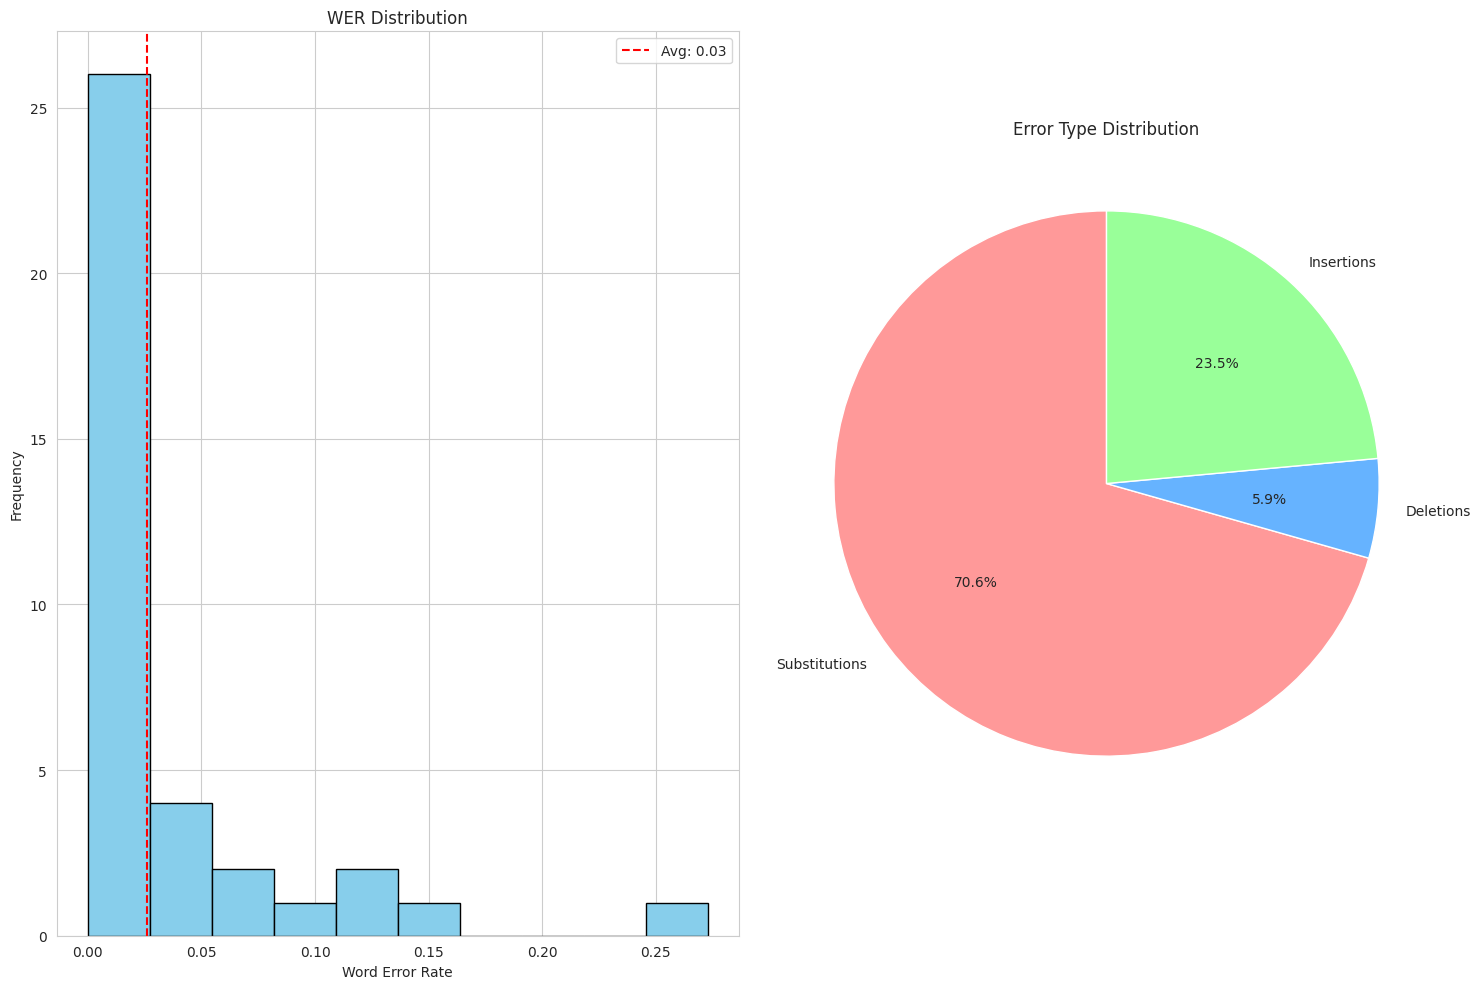


PERFORMANCE SUMMARY
Rating: Excellent


In [19]:
# Q5

from jiwer import process_words


print(" ASR MODEL EVALUATION")


#Loading Whisper ASR model
print("Loading Whisper ASR model")
model = whisper.load_model("base")

# Transcribing audio files
print("\nTranscribing audio files")
predictions = {}


for file_id, audio_info in audio_data.items():

    audio_signal = audio_info['signal'].astype(np.float32)
    result = model.transcribe(audio_signal, language='en', fp16=False)
    predictions[file_id] = result['text'].strip()

print(f"Completed transcription of {len(predictions)} files")

print("\nPreparing texts for WER calculation...")
predictions_processed = {}
references_processed = {}

for file_id in predictions.keys():
    if file_id in transcripts:

        def clean_eval_text(text):
            t = text.lower()
            t = re.sub(r'\d+', '', t)
            t = re.sub(r"[^\w\s']", '', t)
            return ' '.join(t.split())

        predictions_processed[file_id] = clean_eval_text(predictions[file_id])
        references_processed[file_id] = clean_eval_text(transcripts[file_id])

# Calculate WER using JiWER
print("\nCalculating Word Error Rates")
wer_results = []

for file_id in predictions_processed.keys():
    ref = references_processed[file_id]
    hyp = predictions_processed[file_id]
    out = process_words(ref, hyp)

    wer_results.append({
        'file_id': file_id,
        'wer': out.wer,
        'substitutions': out.substitutions,
        'deletions': out.deletions,
        'insertions': out.insertions,
        'total_words': len(ref.split()),
        'duration': audio_data[file_id]['duration']
    })

results_df = pd.DataFrame(wer_results)

#overall stats
total_subs = results_df['substitutions'].sum()
total_dels = results_df['deletions'].sum()
total_ins = results_df['insertions'].sum()
total_words = results_df['total_words'].sum()

overall_wer = (total_subs + total_dels + total_ins) / total_words if total_words > 0 else 0

print("EVALUATION RESULTS")
print(f"\nOverall WER: {overall_wer:.4f} ({overall_wer*100:.2f}%)")
print(f"Average WER per file: {results_df['wer'].mean():.4f}")

print("\nError Breakdown:")
print(f"  Total Substitutions (S): {total_subs}")
print(f"  Total Deletions (D): {total_dels}")
print(f"  Total Insertions (I): {total_ins}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# WER Distribution
axes[0].hist(results_df['wer'], bins=10, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Word Error Rate')
axes[0].set_ylabel('Frequency')
axes[0].set_title('WER Distribution')
axes[0].axvline(overall_wer, color='red', linestyle='--', label=f'Avg: {overall_wer:.2f}')
axes[0].legend()

#  Error Type Distribution
error_types = ['Substitutions', 'Deletions', 'Insertions']
error_counts = [total_subs, total_dels, total_ins]
axes[1].pie(error_counts, labels=error_types, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff', '#99ff99'])
axes[1].set_title('Error Type Distribution')


plt.tight_layout()
plt.show()

# Performance evaluation
print("\nPERFORMANCE SUMMARY")
if overall_wer < 0.05: performance = "Excellent"
elif overall_wer < 0.10: performance = "Good"
else: performance = "Fair/Needs Improvement"
print(f"Rating: {performance}")

## **Q4 D&A**
# **Discussion:**
*  In this final `model evaluation phase`, I implemented an `Automatic Speech Recognition (ASR) system` using `Whisper model` "base" architecture.

*  To assess its performance quantitatively,I employed the `Word Error Rate (WER) metric`.
* Processed the entire dataset of 37 audio files, generating hypothesis transcripts and comparing them against the preprocessed ground truth references.


* Utilized the `jiwer` library to automate the alignment and calculation of specific error types (Substitutions, Deletions, and Insertions).

# **Analysis:**

* The system achieved an overall **WER of 2.60% (0.0260)**. A WER below 5-10% is generally considered professional-grade quality.

* The Pie Chart reveals the distribution of errors:
    * **Substitutions (70.6%)**: This was the most common error type (12 instances). This indicates that the model almost always detects speech but `occasionally make mistakes`.

    * **Deletions (5.9%)**: The `very low deletion rate` (only 1 instance). It means the model rarely "misses" or skips words entirely.

    * **Insertions (23.5%)**: There were 4 instances of insertions, likely caused by the model transcribing a breath sound or expanding a contraction differently than the reference text.

    

# **FINAL REFLECTION**

This project really `simplified` the "black box" of `Automatic Speech Recognition for me`. I understood that  understanding the interplay between audio quality, text processing decisions, and evaluation metrics is crucial for developing robust speech recognition systems. The practical implementation of WER calculation and error
analysis provides valuable insights for improving ASR performance in real-world applications. I also gained a much better intuition for feature extraction. *Overall, while achieving a 2.6% error rate was satisfying, it also gave me a realistic perspective: we were working with "ideal" audiobook data, and I now appreciate how much harder this task would be with messy, real-world conversational speech full of interruptions and background noise.*

# **Acknowledgement:**
Thank you, Professor, for the valuable resources and guidance throughout this project, and to all the TAs for assistance when I am stuck.